In [1]:
###############################################################################
# Imports and arguments
# Check out the repo https://github.com/google/tirg
###############################################################################

In [2]:
import re
import time
import numpy as np
import skimage.io
import json
import random
import PIL
from tqdm import tqdm as tqdm
import sys
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import torch
import torch.utils.data
import torchvision
from tensorboardX import SummaryWriter
import argparse
import os

import word_replacement_list
import datasets

sys.path.append(os.getcwd() + "/tirg")
import text_model
import torch_functions
import img_text_composition_models

In [3]:
torch.set_num_threads(3)
try:
    %matplotlib inline  
    plt.rcParams['figure.figsize'] = (10, 10)
except:
    pass

In [4]:
def parse_opt():
    parser = argparse.ArgumentParser()
    parser.add_argument('-f', type=str, default='f')
    parser.add_argument('--comment', type=str, default='some_comment_here')
    parser.add_argument('--run_id', type=str, default='%d-%0d-%d' % (0, random.randrange(1000), int(time.time())))
    parser.add_argument('--embed_dim', type=int, default=512)
    parser.add_argument('--loader_num_workers', type=int, default=4)
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--num_iters', type=int, default=500000)
    parser.add_argument('--learning_rate', type=float, default=1e-3)
    parser.add_argument('--learning_rate_decay_frequency', type=int, default=200000)
    parser.add_argument('--weight_decay', type=float, default=1e-05)
    parser.add_argument('--test_on_sic112', type=bool, default=False)
    parser.add_argument('--V', type=int, default=3)
    
    args = parser.parse_args()
    
    return args

opt = parse_opt()
print 'Params:', opt
print '=============================================='

if len(opt.f) > 5:
    logger = SummaryWriter(logdir = './notebook_runs/x', comment = opt.comment)
else:
    logger = SummaryWriter(comment = opt.comment)
for k in opt.__dict__.keys():
    logger.add_text(k, str(opt.__dict__[k]))
    
print 'log file saving to ', logger.file_writer.get_logdir()
print 'Run tensorboard there to monitor training progress'
cmd = 'cp *.py "' + logger.file_writer.get_logdir() + '/"'
print cmd
os.system(cmd)
print '=============================================='

Params: Namespace(V=3, batch_size=32, comment='some_comment_here', embed_dim=512, f='/run/user/1002/jupyter/kernel-98b74f53-8325-4444-ad49-6d1112560286.json', learning_rate=0.001, learning_rate_decay_frequency=200000, loader_num_workers=4, num_iters=500000, run_id='0-955-1561236227', test_on_sic112=False, weight_decay=1e-05)
log file saving to  ./notebook_runs/x
Run tensorboard there to monitor training progress
cp *.py "./notebook_runs/x/"


In [5]:
###############################################################################
# Load datasets
# Download the MSCOCO 2014 dataset from http://cocodataset.org
# wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
# wget http://images.cocodataset.org/zips/train2014.zip
# wget http://images.cocodataset.org/zips/val2014.zip
# Unzip into ./datasets/coco
# Make sure the files are:
# ./datasets/coco/annotations/...json
# ./datasets/coco/train2014/...jpg
# ./datasets/coco/val2014/...jpg
###############################################################################

In [6]:
dataset_path = './datasets/coco'

trainset = datasets.COCOCaptionDataset(
    dataset_path,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.3)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    valset = False
)
testset = datasets.COCOCaptionDataset(
    dataset_path,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.3)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    valset = True
)

allsets = [testset, trainset]

print 'Train set:', len(trainset), 'images'
print 'Test set:', len(testset), 'images'

Train set: 82783 images
Test set: 40504 images


['a dog standing on a beach next to a fallen log', 'a dog digging a hole in the sand at the beach', 'a dog digging a hole near the water', 'a dog digs a hole on a beach', 'a dog shakes sand off of its body']


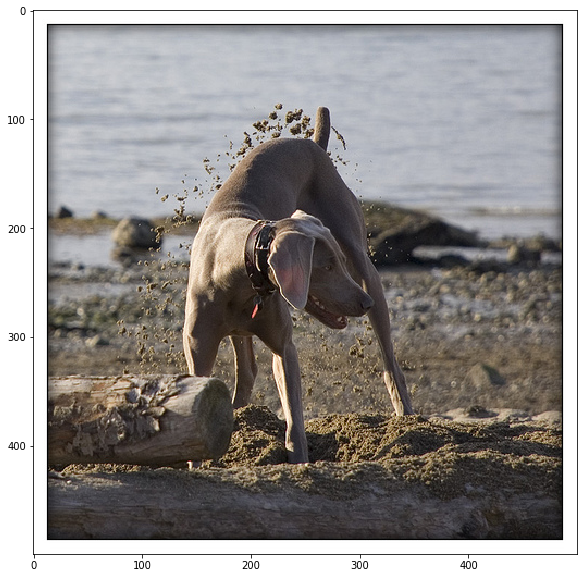

In [7]:
for dataset in allsets:
    dataset.normalize_captions()
    dataset.enable_skip_image_data(False)

x = trainset[1481]
plt.imshow(x['raw_image'])
print x['captions']

In [8]:
###############################################################################
# Create model
###############################################################################

In [9]:
model = torch.nn.Module()
model.norm1 = torch_functions.NormalizationLayer(normalize_scale=4.0, learn_scale=True)

In [10]:
model.text = text_model.TextLSTMModel(
    texts_to_build_vocab=trainset.get_all_texts(),
    word_embed_dim=256,
    lstm_hidden_dim=opt.embed_dim)
model.text.fc_output = torch.nn.Sequential(
    torch.nn.Dropout(0.1),
    torch.nn.Linear(opt.embed_dim, 2048),
    torch.nn.BatchNorm1d(2048),
    torch.nn.Dropout(0.1),
    torch.nn.ReLU(),
    torch.nn.Linear(2048, opt.embed_dim)
)
model.text.vocab.threshold_rare_words(5)

In [11]:
model.image = torchvision.models.resnet50(pretrained=True)
model.image.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(2048, 2048),
    torch.nn.BatchNorm1d(2048),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(2048, opt.embed_dim)
)

In [12]:
# Composition by concat
class C1(torch.nn.Module):
    def __init__(self, embed_dim):
        super(C1, self).__init__()
        self.m = torch.nn.Sequential(
            torch.nn.Linear(embed_dim * 3, embed_dim * 5),
            torch.nn.ReLU(),
            torch.nn.Linear(embed_dim * 5, embed_dim * 5),
            torch.nn.BatchNorm1d(embed_dim * 5),
            torch.nn.ReLU(),
            torch.nn.Linear(embed_dim * 5, embed_dim)
        )
        self.norm = torch_functions.NormalizationLayer(normalize_scale=1.0, learn_scale=False)

    def forward(self, x):
        f = torch.cat([self.norm(i) for i in x], dim=1)
        f = self.m(f)
        return f
    
# Composition by TIRG (no gating)
class C2(torch.nn.Module):
    def __init__(self, embed_dim):
        super(C2, self).__init__()

    def forward(self, x):
        return None
    
model.transform_module = C2(embed_dim = opt.embed_dim)
model.transform_module = C1(embed_dim = opt.embed_dim)

In [13]:
model = model.cuda()

In [14]:
###############################################################################
# Compute image features and cache
###############################################################################

In [15]:
cached_image_features = None

def load_cached_image_features():
    return np.load('cached_image_features.23523.npy').item()
def save_cached_image_features(cached_image_features):
    np.save('cached_image_features.23523', cached_image_features)

img_model_conv = model.image
model.image = model.image.fc
img_model_conv.fc = torch.nn.Dropout(0.0)
img_model_conv = img_model_conv.eval()

try:
    cached_image_features = load_cached_image_features()
except:
    cached_image_features = {}
    for _ in range(opt.V):
      for dataset in allsets:
        for data in tqdm(dataset.get_loader(batch_size=opt.batch_size, shuffle=True,
                                            drop_last=False, num_workers=opt.loader_num_workers)):

            img1 = np.stack([d['image'] for d in data])
            img1 = torch.from_numpy(img1).float()
            img1 = torch.autograd.Variable(img1).cuda()
            img1 = img_model_conv(img1)

            img1 = img1.cpu().data.numpy()
            for i, idx in enumerate([d['id'] for d in data]):
                try:
                    cached_image_features[idx]
                except:
                    cached_image_features[idx] = []
                cached_image_features[idx] += [img1[i,:]]

    save_cached_image_features(cached_image_features)

for dataset in allsets:
    dataset.enable_skip_image_data(True)

img_model_conv = None

for k in tqdm(cached_image_features):
    for i in range(opt.V):
        cached_image_features[k][i] = torch.from_numpy(cached_image_features[k][i])

for dataset in allsets:
    dataset.enable_skip_image_data(True)

100%|██████████| 123287/123287 [00:02<00:00, 46431.32it/s]


In [16]:
###############################################################################
# Optimizer
###############################################################################

In [17]:
# create optimizer
params = []
if cached_image_features is None:
    params.append({'params': [p for p in model.image.fc.parameters()]})
    params.append({'params': [p for p in model.image.parameters()], 'lr': 0.0 * opt.learning_rate})
else:
    params.append({'params': [p for p in model.image.parameters()], 'lr': 1 * opt.learning_rate})
params.append({'params': [p for p in model.text.parameters()], 'lr': 1 * opt.learning_rate})

params.append({'params': [p for p in model.transform_module.parameters()], 'weight_decay': opt.weight_decay * 0.1})

params.append({'params': [p for p in model.parameters()]})

# remove dup params (keep the first one)
for i1, p1 in enumerate(params):
  for i2, p2 in enumerate(params):
    if p1 is not p2:
      for p11 in p1['params']:
        for j, p22 in enumerate(p2['params']):
          if p11 is p22:
            p2['params'][j] = torch.tensor(0.0, requires_grad=True)

optimizer = torch.optim.Adam(
    params,
    lr=opt.learning_rate,
    weight_decay=opt.weight_decay
)

In [18]:
###############################################################################
# Test function 
###############################################################################

In [19]:
def extract_features_from_dataset(model, testset, img_stop_num):
    model.eval()
    x = []
    for _ in range(opt.V):
      try:
        x += [img_features]
      except:
        pass
      all_texts = []
      img_features = []
      text_features = []
      img_labels = []
      text_labels = []
        
      for data in (testset.get_loader(batch_size = opt.batch_size, shuffle = False, drop_last = False)):
        # extract image features
        if cached_image_features is None:
            img1 = np.stack([d['image'] for d in data])
            img1 = torch.from_numpy(img1).float()
        else:
            idx = [d['id'] for d in data]
            img1 = torch.stack([cached_image_features[i][0] for i in idx])
        img1 = torch.autograd.Variable(img1).cuda()
        img1 = model.image(img1)
        img1 = model.norm1(img1)
        img1 = img1.data.cpu().numpy()
        
        img_features += [img1]
        img_labels += [d['id'] for d in data]

        # text
        texts = []
        for d in data:
            texts += d['captions']
            text_labels += [d['id'] for c in d['captions']]
        all_texts += texts
        texts = model.text(texts)
        texts = model.norm1(texts)
        texts = texts.data.cpu().numpy()
        text_features += [texts]

        if len(img_labels) > img_stop_num:
            break

    img_features = np.concatenate(x[0], axis=0) * 0.0
    for xi in x:
        img_features += np.concatenate(xi, axis=0) / 10.0
    text_features = np.concatenate(text_features, axis=0)
    
    return img_features, img_labels, text_features, text_labels

def test_text_to_image_retrieval(model, testset):
    img_features, img_labels, text_features, text_labels = extract_features_from_dataset(model, testset, img_stop_num = 1100)
    
    # text to image
    sims = text_features.dot(img_features.T)
    r1 = 0.0
    for i in range(sims.shape[0]):
        s = -sims[i,:]
        s = np.argsort(s)
        if text_labels[i] == img_labels[s[0]]:
            r1 += 1
    r1 /= sims.shape[0]
    return [('text_to_image_retrieval_r1', r1)]

def test_function(model, testset):
    return  test_text_to_image_retrieval(model, testset)

In [20]:
###############################################################################
# Alright lets train
# monitor progress with tensorbard 
###############################################################################

In [21]:
it = 0
losses_tracking = {}

print 'begin training'
first_iter_done = False
tic = time.time()

begin training


In [22]:
for epoch in range(999):
    if it >= opt.num_iters:
        break
        
    ##########################################
    # stat
    ##########################################
    print 'Elapsed time', round(time.time() - tic, 4), opt.comment
    tic = time.time()
    for loss_name in losses_tracking:
        avg_loss = np.mean(losses_tracking[loss_name][-int(len(trainset) / opt.batch_size):])
        print it, epoch, loss_name, round(avg_loss, 4)
        logger.add_scalar(loss_name, avg_loss, it)
    logger.add_scalar('learning_rate', optimizer.param_groups[0]['lr'] , it)
    

    if 1:
        tests = []
        for dataset in allsets:
            if len(dataset) > 0:
                t = test_function(model, dataset)
                tests += [(dataset.name() + ' ' + metric_name, metric_value) for metric_name, metric_value in t]
                pass
            
        for metric_name, metric_value in tests:
            print it, epoch, metric_name, round(metric_value, 4)
        for metric_name, metric_value in tests:
            logger.add_scalar(metric_name, metric_value, it)
    
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'it': it,
        }, 'text2image.coco.torchdata')

    ##########################################
    # train
    ##########################################
    for data in tqdm(trainset.get_loader(batch_size=opt.batch_size, shuffle=True,
                                         drop_last=True, num_workers=opt.loader_num_workers),
                     desc = 'Training for epoch ' + str(epoch)):
        it += 1
        model.train()
        losses = []
        
        # learing rate scheduling
        if it >= opt.learning_rate_decay_frequency and it % opt.learning_rate_decay_frequency == 0:
            for g in optimizer.param_groups:
                g['lr'] *= 0.1

        # extract image features
        if cached_image_features is None:
            img1 = np.stack([d['image'] for d in data])
            img1 = torch.from_numpy(img1).float()
        else:
            idx = [d['id'] for d in data]
            img1 = torch.stack([random.choice(cached_image_features[i]) for i in idx])
        img1 = torch.autograd.Variable(img1).cuda()
        img1 = model.image(img1)

        # extract text features
        texts = [random.choice(d['captions']) for d in data]
        texts = model.text(texts)

        # loss: joint embedding
        def self_classification_loss(x):
            assert(x.shape[0] == x.shape[1])
            labels = torch.tensor(range(x.shape[0])).long()
            labels = labels.cuda()
            loss = torch.nn.functional.cross_entropy(x, labels)
            return loss
        def pair_loss(a, b):
            a = model.norm1(a)
            b = model.norm1(b).transpose(0,1)
            x = torch.mm(a, b)
            if random.random() > 0.5:
                x = x.transpose(0, 1)
            return self_classification_loss(x)
        loss_name = 'loss_image_text_joint_embedding'
        loss_value = pair_loss(texts, img1)
        loss_weight = 1.0
        losses += [(loss_name, loss_weight, loss_value)]
        
        # transformation transferring
        if epoch >= 1:
            source_texts = []
            target_texts = []
            replace_words = []
            target_imgs = []
            for i in range(opt.batch_size):
                source_text, target_text, replace_word = word_replacement_list.find_a_text_to_replace(data[i]['captions'])
                if source_text is not None:
                    source_texts += [source_text]
                    target_texts += [target_text]
                    replace_words += [replace_word]
                    target_imgs += [img1[i,:]]
            source_words = [i[0] for i in replace_words]
            target_words = [i[1] for i in replace_words]
            target_imgs = torch.stack(target_imgs)

            if len(source_texts) >= opt.batch_size / 2:
                source_texts = model.text(source_texts)
                target_texts = model.text(target_texts)
                source_words = model.text(source_words)
                target_words = model.text(target_words)
                target_imgs = target_imgs
                if True:
                    source_texts = source_texts.detach()
                    target_texts = target_texts.detach()
                    source_words = source_words.detach()
                    target_words = target_words.detach()
                    target_imgs = target_imgs.detach()

                source_texts_to_target = model.transform_module((source_texts, source_words, target_words))
                target_texts_to_source = model.transform_module((target_texts, target_words, source_words))
                target_imgs_to_source = model.transform_module((target_imgs, target_words, source_words))
                target_imgs_to_source_to_target = model.transform_module((target_imgs_to_source, source_words, target_words))
                pairs = [
                    (target_imgs_to_source, source_texts),
                    (target_imgs, source_texts_to_target),
                    (torch.cat((source_texts_to_target, target_texts_to_source)), torch.cat((target_texts, source_texts))),
                    (torch.cat((source_texts_to_target, target_imgs_to_source)), torch.cat((target_imgs, source_texts))),
                    (torch.cat((target_imgs, target_imgs_to_source)), torch.cat((target_texts, source_texts))),
                ]
                i = 0
                for a, b in pairs:
                    i += 1
                    loss_value = pair_loss(a, b)
                    loss_name = 'loss_transformation' + str(i)
                    loss_weight = 1.0 / len(pairs)
                    losses += [(loss_name, loss_weight, loss_value)]
                

        # loss: total
        loss_name = 'total training loss'
        loss_value = sum([w * v for _, w, v in losses])
        assert(not torch.isnan(loss_value))
        loss_weight = None
        losses += [(loss_name, loss_weight, loss_value)]

        # backward & step
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        if not first_iter_done:
            first_iter_done = True
            print 'First iter done!'
        
        # save losses
        for loss_name, loss_weight, loss_value in losses:
            if not losses_tracking.has_key(loss_name):
                losses_tracking[loss_name] = []
            losses_tracking[loss_name].append(loss_value.data.item())
        losses = []

Elapsed time 0.2475 some_comment_here


Training for epoch 0:   0%|          | 0/2586 [00:00<?, ?it/s]

0 0 CocoCap2014val text_to_image_retrieval_r1 0.0018
0 0 CocoCap2014train text_to_image_retrieval_r1 0.0018


Training for epoch 0:   0%|          | 5/2586 [00:00<13:21,  3.22it/s]

First iter done!


Training for epoch 0: 100%|██████████| 2586/2586 [01:15<00:00, 34.08it/s]


Elapsed time 79.9765 some_comment_here
2586 1 total training loss 1.1424
2586 1 loss_image_text_joint_embedding 1.1424
2586 1 CocoCap2014val text_to_image_retrieval_r1 0.1174
2586 1 CocoCap2014train text_to_image_retrieval_r1 0.1194


Training for epoch 1: 100%|██████████| 2586/2586 [03:09<00:00, 13.68it/s]


Elapsed time 193.1344 some_comment_here
5172 2 loss_image_text_joint_embedding 0.7089
5172 2 loss_transformation5 1.2558
5172 2 loss_transformation4 1.6465
5172 2 total training loss 1.8759
5172 2 loss_transformation1 0.6869
5172 2 loss_transformation3 1.3103
5172 2 loss_transformation2 0.936
5172 2 CocoCap2014val text_to_image_retrieval_r1 0.1547
5172 2 CocoCap2014train text_to_image_retrieval_r1 0.1542


Training for epoch 2: 100%|██████████| 2586/2586 [03:09<00:00, 13.66it/s]


Elapsed time 193.743 some_comment_here
7758 3 loss_image_text_joint_embedding 0.6149
7758 3 loss_transformation5 1.088
7758 3 loss_transformation4 1.2893
7758 3 total training loss 1.5785
7758 3 loss_transformation1 0.5137
7758 3 loss_transformation3 1.1429
7758 3 loss_transformation2 0.7842
7758 3 CocoCap2014val text_to_image_retrieval_r1 0.1738
7758 3 CocoCap2014train text_to_image_retrieval_r1 0.1774


Training for epoch 3: 100%|██████████| 2586/2586 [03:09<00:00, 13.66it/s]


Elapsed time 193.8158 some_comment_here
10344 4 loss_image_text_joint_embedding 0.5539
10344 4 loss_transformation5 1.0065
10344 4 loss_transformation4 1.0246
10344 4 total training loss 1.4034
10344 4 loss_transformation1 0.44
10344 4 loss_transformation3 1.0729
10344 4 loss_transformation2 0.7034
10344 4 CocoCap2014val text_to_image_retrieval_r1 0.1763
10344 4 CocoCap2014train text_to_image_retrieval_r1 0.1892


Training for epoch 4: 100%|██████████| 2586/2586 [03:09<00:00, 13.62it/s]


Elapsed time 194.4519 some_comment_here
12930 5 loss_image_text_joint_embedding 0.5129
12930 5 loss_transformation5 0.9532
12930 5 loss_transformation4 0.8656
12930 5 total training loss 1.2925
12930 5 loss_transformation1 0.3943
12930 5 loss_transformation3 1.0273
12930 5 loss_transformation2 0.6572
12930 5 CocoCap2014val text_to_image_retrieval_r1 0.1891
12930 5 CocoCap2014train text_to_image_retrieval_r1 0.204


Training for epoch 5: 100%|██████████| 2586/2586 [03:09<00:00, 13.66it/s]


Elapsed time 193.7605 some_comment_here
15516 6 loss_image_text_joint_embedding 0.4916
15516 6 loss_transformation5 0.9175
15516 6 loss_transformation4 0.7782
15516 6 total training loss 1.2267
15516 6 loss_transformation1 0.3593
15516 6 loss_transformation3 0.9942
15516 6 loss_transformation2 0.6263
15516 6 CocoCap2014val text_to_image_retrieval_r1 0.2071
15516 6 CocoCap2014train text_to_image_retrieval_r1 0.2097


Training for epoch 6:  67%|██████▋   | 1739/2586 [02:07<01:00, 13.91it/s]

KeyboardInterrupt: 

In [ ]:
###############################################################################
# Qualitative test
###############################################################################

In [26]:
dataset = testset
img_features, _, _, _ = extract_features_from_dataset(model, dataset, len(dataset))

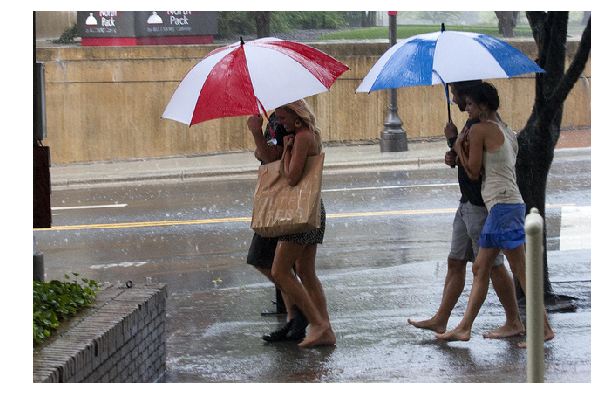

Query image 1454
Replace street with kitchen


In [41]:
model.eval()
image_query_id = 1454
source_words = ['street']
target_words = ['kitchen']

dataset.enable_skip_image_data(False)
img = dataset[image_query_id]
dataset.enable_skip_image_data(True)
plt.imshow(img['raw_image'])
plt.axis('off')
plt.show()
print 'Query image', image_query_id
print 'Replace', source_words[0], 'with', target_words[0]

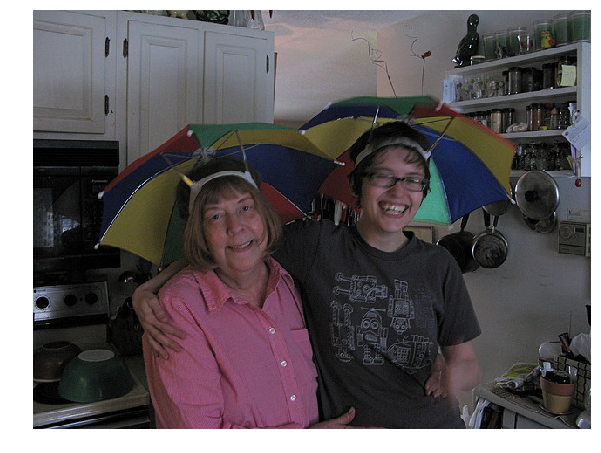

Ranked 1 similarity score 153.28668


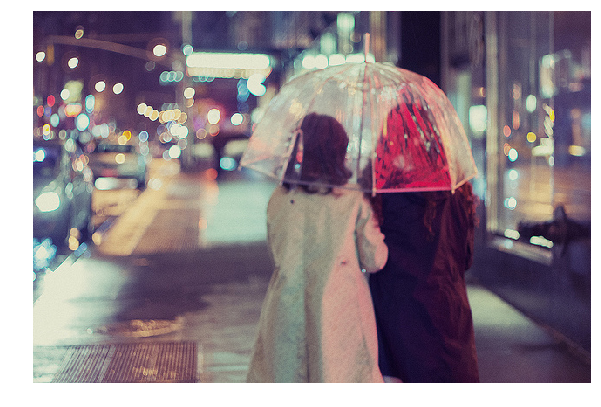

Ranked 2 similarity score 152.1993


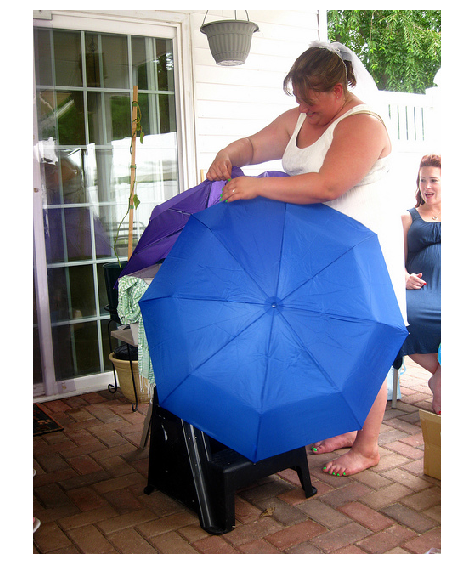

Ranked 3 similarity score 150.63194


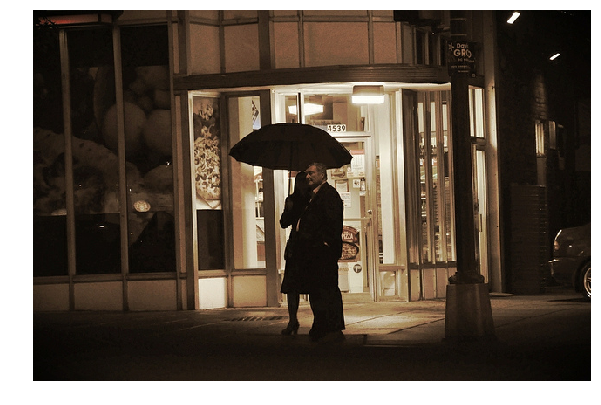

Ranked 4 similarity score 148.53601


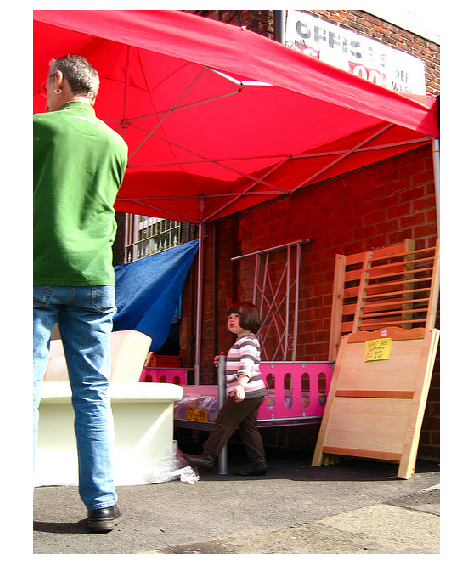

Ranked 5 similarity score 147.36002
The End


In [42]:
source_words = model.text(source_words)
target_words = model.text(target_words)
source_img = img_features[image_query_id:(image_query_id+1),:]
source_img = torch.from_numpy(source_img).cuda()
source_img_to_target = model.transform_module((source_img, source_words, target_words))
query = source_img_to_target.cpu().data.numpy()

sim = np.matmul(query, img_features.T)
ranked = np.argsort(sim)

dataset.enable_skip_image_data(False)
for i in range(5):
    k = ranked[0,-i-1]
    img = dataset[k]
    plt.axis('off')
    plt.imshow(img['raw_image'])
    plt.show()
    print 'Ranked', i+1, 'similarity score', sim[0, k]
    time.sleep(1)
dataset.enable_skip_image_data(True)
print 'The End'